# t-SNE example

This is adapted from the following article: 

An illustrated introduction to the t-SNE algorithm By Cyrille Rossant

https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm

In [1]:
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
# from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

%matplotlib inline

load the classic handwritten digits datasets. It contains 1797 images with 8∗8=64 pixels each

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

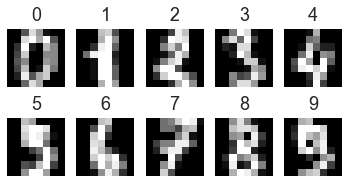

In [2]:
digits = load_digits()
digits.data.shape
print(digits['DESCR'])
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])
plt.savefig('images/digits-generated.png', dpi=150)

Now let’s run the t-SNE algorithm on the dataset. It just takes one line with scikit-learn.

In [3]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

digits_proj = TSNE(random_state=RS).fit_transform(X)

Here is a utility function used to display the transformed dataset. The color of each point refers to the actual digit (of course, this information was not used by the dimensionality reduction algorithm).

In [27]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
#     plt.xlim(-25, 25)
#     plt.ylim(-25, 25)
    ax.axis('square')
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

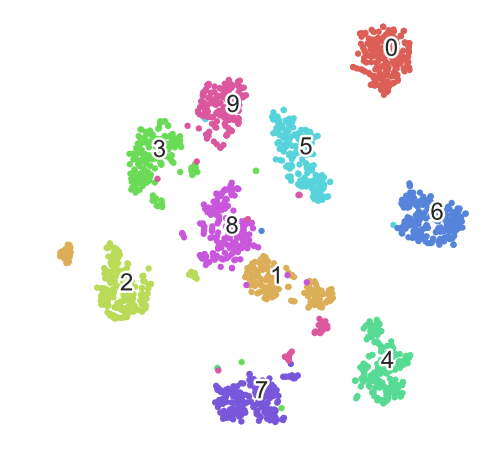

In [5]:
scatter(digits_proj, y)
plt.savefig('images/digits_tsne-generated.png', dpi=120)

Similarity matrix
The following function computes the similarity with a constant σ.

In [6]:
def _joint_probabilities_constant_sigma(D, sigma):
    P = np.exp(-D**2/2 * sigma**2)
    P /= np.sum(P, axis=1)
    return P


We now compute the similarity with a σi depending on the data point (found via a binary search, according to the original t-SNE paper). This algorithm is implemented in the _joint_probabilities private function in scikit-learn’s code.

In [7]:
# Pairwise distances between all data points.
D = pairwise_distances(X, squared=True)
# Similarity with constant sigma.
P_constant = _joint_probabilities_constant_sigma(D, .002)
# Similarity with variable sigma.
P_binary = _joint_probabilities(D, 30., False)
# The output of this function needs to be reshaped to a square matrix.
P_binary_s = squareform(P_binary)

We can now display the distance matrix of the data points, and the similarity matrix with both a constant and variable sigma.



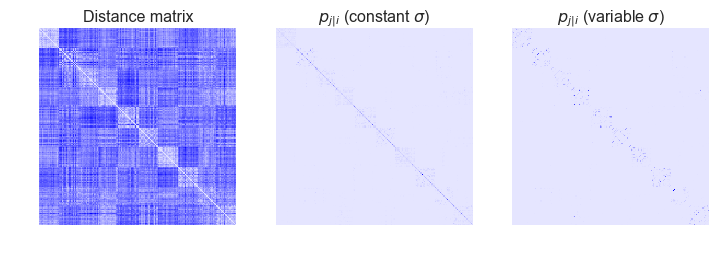

In [8]:
plt.figure(figsize=(12, 4))
pal = sns.light_palette("blue", as_cmap=True)

plt.subplot(131)
plt.imshow(D[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("Distance matrix", fontdict={'fontsize': 16})

plt.subplot(132)
plt.imshow(P_constant[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("$p_{j|i}$ (constant $\sigma$)", fontdict={'fontsize': 16})

plt.subplot(133)
plt.imshow(P_binary_s[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("$p_{j|i}$ (variable $\sigma$)", fontdict={'fontsize': 16})
plt.savefig('images/similarity-generated.png', dpi=120)

We can already observe the 10 groups in the data, corresponding to the 10 numbers.

Let’s also define a similarity matrix for our map points.

qij=f(|xi−xj|)∑k≠if(|xi−xk|)withf(z)=11+z2

This is the same idea as for the data points, but with a different distribution (t-Student with one degree of freedom, or Cauchy distribution, instead of a Gaussian distribution). We’ll elaborate on this choice later.

Whereas the data similarity matrix (pij) is fixed, the map similarity matrix (qij) depends on the map points. What we want is for these two matrices to be as close as possible. This would mean that similar data points yield similar map points.

## Algorithm

Remarkably, this physical analogy stems naturally from the mathematical algorithm. It corresponds to minimizing the Kullback-Leiber divergence between the two distributions (pij) and (qij):

KL(P||Q)=∑i,jpijlogpijqij.

This measures the distance between our two similarity matrices.

To minimize this score, we perform a gradient descent. The gradient can be computed analytically:

∂KL(P||Q)∂yi=4∑j(pij−qij)g(|xi−xj|)uijwhereg(z)=z1+z2.

Here, uij is a unit vector going from yj to yi. This gradient expresses the sum of all spring forces applied to map point i.

Let’s illustrate this process by creating an animation of the convergence. We’ll have to monkey-patch the internal _gradient_descent() function from scikit-learn’s t-SNE implementation in order to register the position of the map points at every iteration.

In [18]:
# This list will contain the positions of the map points at every iteration.
positions = []
from time import time
def _gradient_descent(objective, p0, it, n_iter,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):

    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    tic = time()
    for i in range(it, n_iter):
        # We save the current position.
        positions.append(p.copy())
        
        check_convergence = (i + 1) % n_iter_check == 0
        # only compute the error when needed
#         kwargs['compute_error'] = check_convergence or i == n_iter - 1

        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:
            toc = time()
            duration = toc - tic
            tic = toc

            if verbose >= 2:
                print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      " (%s iterations in %0.3fs)"
                      % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                          "during the last %d episodes. Finished."
                          % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                          % (i + 1, grad_norm))
                break

    return p, error, i


# def _gradient_descent(objective, p0, it, n_iter,
#                       n_iter_check=1, n_iter_without_progress=300,
#                       momentum=0.8, learning_rate=200.0, min_gain=0.01,
#                       min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):
#     # The documentation of this function can be found in scikit-learn's code.
#     if args is None:
#         args = []
#     if kwargs is None:
#         kwargs = {}
        
#     p = p0.copy().ravel()
#     update = np.zeros_like(p)
#     gains = np.ones_like(p)
#     error = np.finfo(np.float).max
#     best_error = np.finfo(np.float).max
#     best_iter = 0

#     for i in range(it, n_iter):
#         # We save the current position.
#         positions.append(p.copy())

#         new_error, grad = objective(p, *args)
#         error_diff = np.abs(new_error - error)
#         error = new_error
#         grad_norm = linalg.norm(grad)

#         if error < best_error:
#             best_error = error
#             best_iter = i
#         elif i - best_iter > n_iter_without_progress:
#             break
#         if min_grad_norm >= grad_norm:
#             break
#         if min_error_diff >= error_diff:
#             break

#         inc = update * grad >= 0.0
#         dec = np.invert(inc)
#         gains[inc] += 0.05
#         gains[dec] *= 0.95
#         np.clip(gains, min_gain, np.inf)
#         grad *= gains
#         update = momentum * update - learning_rate * grad
#         p += update

#     return p, error, i
sklearn.manifold.t_sne._gradient_descent = _gradient_descent

Let’s run the algorithm again, but this time saving all intermediate positions.

In [19]:
X_proj = TSNE(random_state=RS).fit_transform(X)

X_iter = np.dstack(position.reshape(-1, 2)
                   for position in positions)

In [20]:
print(positions)

[array([ 2.2526995e-04, -4.1792318e-06,  2.7974791e-06, ...,
        4.8178445e-05, -1.7938757e-04,  1.7921962e-05], dtype=float32), array([-8.9315174e-04,  1.7926369e-04, -4.0164297e-05, ...,
       -2.2130084e-04,  3.6321720e-04,  1.7471530e-05], dtype=float32), array([ 0.00253133, -0.00076726,  0.000231  , ...,  0.00086188,
       -0.00047888, -0.00019027], dtype=float32), array([-0.00469047,  0.00218306, -0.00050634, ..., -0.00273905,
        0.00026411,  0.00061529], dtype=float32), array([ 0.00535331, -0.00398232,  0.00112811, ...,  0.00647509,
        0.00037145, -0.00111661], dtype=float32), array([-0.00234399,  0.00405198, -0.00156547, ..., -0.00984066,
       -0.00062004,  0.00104068], dtype=float32), array([-1.3671471e-03, -1.0043341e-03,  1.0535324e-03, ...,
        7.6619573e-03,  7.2805502e-05, -2.5851524e-04], dtype=float32), array([ 0.00330377, -0.00172131,  0.00042507, ..., -0.00017289,
        0.0003745 , -0.00033426], dtype=float32), array([-0.00247028,  0.00029357, 

We create an animation using MoviePy.



100%|█████████▉| 500/501 [00:09<00:00, 51.35it/s]


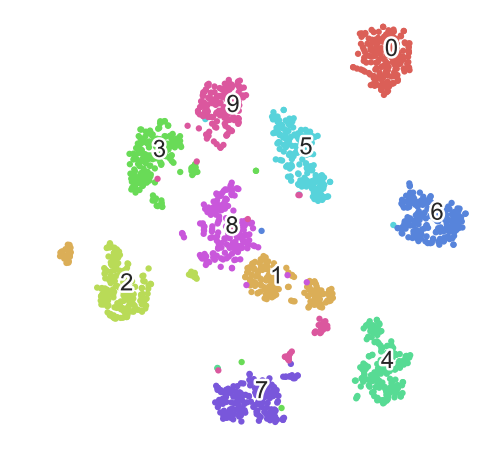

In [28]:
f, ax, sc, txts = scatter(X_iter[..., -1], y)

def make_frame_mpl(t):
    i = int(t*40)
    x = X_iter[..., i]
    sc.set_offsets(x)
    for j, txt in zip(range(10), txts):
        xtext, ytext = np.median(x[y == j, :], axis=0)
        txt.set_x(xtext)
        txt.set_y(ytext)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
# animation.write_gif("https://d3ansictanv2wj.cloudfront.net/images/animation-94a2c1ff.gif", fps=20)
# animation.write_gif("images/t-sne.gif", fps=20)
animation.ipython_display(fps=20, loop=True, autoplay=True)


Let’s also create an animation of the similarity matrix of the map points. We’ll observe that it’s getting closer and closer to the similarity matrix of the data points.

100%|█████████▉| 500/501 [00:26<00:00, 19.07it/s]


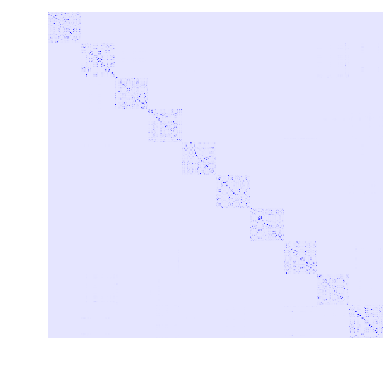

In [26]:
n = 1. / (pdist(X_iter[..., -1], "sqeuclidean") + 1)
Q = n / (2.0 * np.sum(n))
Q = squareform(Q)

f = plt.figure(figsize=(6, 6))
ax = plt.subplot(aspect='equal')
im = ax.imshow(Q, interpolation='none', cmap=pal)
plt.axis('tight')
plt.axis('off')

def make_frame_mpl(t):
    i = int(t*40)
    n = 1. / (pdist(X_iter[..., i], "sqeuclidean") + 1)
    Q = n / (2.0 * np.sum(n))
    Q = squareform(Q)
    im.set_data(Q)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
# animation.write_gif("images/animation_matrix.gif", fps=20)
animation.ipython_display(fps=20, loop=True, autoplay=True)


The t-Student distribution
Let’s now explain the choice of the t-Student distribution for the map points, while a normal distribution is used for the data points. It is well known that the volume of the N-dimensional ball of radius r scales as rN. When N is large, if we pick random points uniformly in the ball, most points will be close to the surface, and very few will be near the center.

This is illustrated by the following simulation, showing the distribution of the distances of these points, for different dimensions.

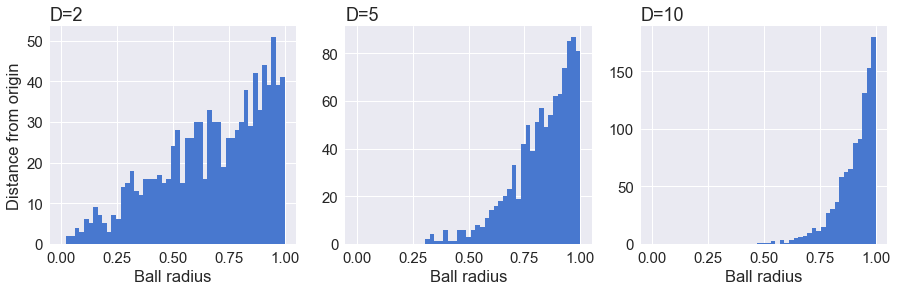

In [9]:
npoints = 1000
plt.figure(figsize=(15, 4))
for i, D in enumerate((2, 5, 10)):
    # Normally distributed points.
    u = np.random.randn(npoints, D)
    # Now on the sphere.
    u /= norm(u, axis=1)[:, None]
    # Uniform radius.
    r = np.random.rand(npoints, 1)
    # Uniformly within the ball.
    points = u * r**(1./D)
    # Plot.
    ax = plt.subplot(1, 3, i+1)
    ax.set_xlabel('Ball radius')
    if i == 0:
        ax.set_ylabel('Distance from origin')
    ax.hist(norm(points, axis=1),
            bins=np.linspace(0., 1., 50))
    ax.set_title('D=%d' % D, loc='left')
# plt.savefig('images/spheres-generated.png', dpi=100, bbox_inches='tight')

When reducing the dimensionality of a dataset, if we used the same Gaussian distribution for the data points and the map points, we would get an imbalance in the distribution of the distances of a point’s neighbors. This is because the distribution of the distances is so different between a high-dimensional space and a low-dimensional space. Yet, the algorithm tries to reproduce the same distances in the two spaces. This imbalance would lead to an excess of attraction forces and a sometimes unappealing mapping. This is actually what happens in the original SNE algorithm, by Hinton and Roweis (2002).

The t-SNE algorithm works around this problem by using a t-Student with one degree of freedom (or Cauchy) distribution for the map points. This distribution has a much heavier tail than the Gaussian distribution, which compensates the original imbalance. For a given similarity between two data points, the two corresponding map points will need to be much further apart in order for their similarity to match the data similarity. This can be seen in the following plot.

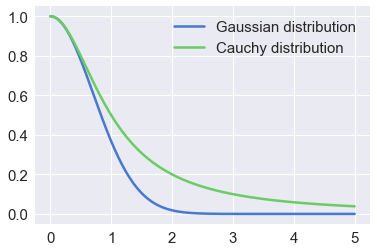

In [8]:
z = np.linspace(0., 5., 1000)
gauss = np.exp(-z**2)
cauchy = 1/(1+z**2)
plt.plot(z, gauss, label='Gaussian distribution')
plt.plot(z, cauchy, label='Cauchy distribution')
plt.legend()
# plt.savefig('images/distributions-generated.png', dpi=100)